# Cheminformatics/Machine Learning

#### Import packages

In [5]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import recall_score, confusion_matrix
from rdkit.Chem import MACCSkeys
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from rdkit.Chem import rdFMCS
from rdkit.Chem import Draw

### Task 1: Read .csv file

In [6]:
df = pd.read_csv("../data/CHEMBL25_activities_EGFR.csv")
df.head()

,Unnamed: 0,chembl_id,IC50,units,canonical_smiles,pIC50
0,1777,CHEMBL207869,77.0,nM,Fc1cccc(COc2ccc(Nc3ncncc3C#Cc4ncccn4)cc2Cl)c1,7.113509
1,5785,CHEMBL3940060,330.0,nM,Fc1ccc(Nc2ncnc3cc4OC(=O)N(CCOC(=O)CCl)c4cc23)c...,6.481486
2,6373,CHEMBL3678951,1.0,nM,CC(C)n1c(Nc2cccc(c2)C(F)(F)F)nc3cnc(Nc4ccc(cc4...,9.000000
3,2442,CHEMBL504034,40.0,nM,CS(=O)(=O)CCNC(=O)O[C@H]1CN[C@@H](C1)C#Cc2cc3n...,7.397940
4,1084,CHEMBL158797,43000.0,nM,Cn1c(SSc2c(C(=O)NCC(O)CO)c3ccccc3n2C)c(C(=O)NC...,4.366532


### Task 2: Separate the table into actives and inactives according to pIC50 of threshold >= 6.3 being actives

In [7]:
actives_df = df[df['pIC50'] >= 6.3]
actives_df.drop('Unnamed: 0', axis=1, inplace=True)
inactives_df = df[df['pIC50'] < 6.3]
inactives_df.drop('Unnamed: 0', axis=1, inplace=True)

C:\Users\Heshine G\AppData\Local\Temp\ipykernel_22704\1807368482.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actives_df.drop('Unnamed: 0', axis=1, inplace=True)
C:\Users\Heshine G\AppData\Local\Temp\ipykernel_22704\1807368482.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inactives_df.drop('Unnamed: 0', axis=1, inplace=True)


In [8]:
active_count = len(actives_df)
inactive_count = len(inactives_df)
total_count = active_count + inactive_count
counts_df = pd.DataFrame({'ChEMBL25': [active_count, inactive_count, total_count]}, 
                         index=['Actives', 'Inactives', 'Sum'])
counts_df

,ChEMBL25
Actives,2214
Inactives,1692
Sum,3906


### Task 3: Random forest

#### Generate fingerprints 

In [13]:
smiles_active = actives_df["canonical_smiles"].tolist()
smiles_inactive = inactives_df["canonical_smiles"].tolist()
def fingerprints(smiles_list, fingerprint_type):
    fingerprints = []
    for smiles in smiles_list:
        molecule = Chem.MolFromSmiles(smiles)
        if fingerprint_type == "morgan":
            fingerprint = AllChem.GetMorganFingerprintAsBitVect(molecule, radius=2, nBits=1024)
        elif fingerprint_type == "maccs":
            fingerprint = MACCSkeys.GenMACCSKeys(molecule)
        fingerprints.append(fingerprint)
    return fingerprints

morgan_active_fp = fingerprints(smiles_active, "morgan")
morgan_inactive_fp = fingerprints(smiles_inactive, "morgan")
fps_morgan = morgan_active_fp + morgan_inactive_fp
active_morgan_y = np.ones(len(morgan_active_fp))
inactive_morgan_y = np.zeros(len(morgan_inactive_fp))
morgan_y = np.concatenate([active_morgan_y, inactive_morgan_y])

maccs_active_fp = fingerprints(smiles_active, "maccs")
maccs_inactive_fp = fingerprints(smiles_inactive, "maccs")
fps_maccs = maccs_active_fp + maccs_inactive_fp
active_maccs_y = np.ones(len(maccs_active_fp))
inactive_maccs_y = np.zeros(len(maccs_inactive_fp))
maccs_y = np.concatenate([active_maccs_y, inactive_maccs_y])

#### Evaluate metrics

In [14]:
def evaluate_metrics(y_true, y_pred, y_prob):
    accuracy = metrics.accuracy_score(y_true, y_pred)
    auc_score = metrics.roc_auc_score(y_true, y_prob)
    sensitivity = recall_score(y_true, y_pred)
    specificity = recall_score(y_true, y_pred, pos_label=0)
    return accuracy, auc_score, sensitivity, specificity

#### Train a random forest model

In [15]:
def random_forest(X, y, fingerprint_type=None, plot_roc=False, return_forest=False):
    def plot_roc_curve(fpr, tpr, roc_auc, title):
        plt.figure()
        plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='red', linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(title)
        plt.legend(loc='lower right')
        plt.show()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)
    forest = RandomForestClassifier(n_jobs=-1, n_estimators=100, max_features=100, random_state=0)
    forest.fit(X_train, y_train)
    y_pred = forest.predict(X_test)
    y_prob = forest.predict_proba(X_test)[:, 1]
    accuracy, auc_score, sensitivity, specificity = evaluate_metrics(y_test, y_pred, y_prob)
    results = {
        " ": fingerprint_type,
        "Accuracy": accuracy,
        "AUC": auc_score,
        "Sensitivity": sensitivity,
        "Specificity": specificity,
    }
    if plot_roc:
        fpr, tpr, _ = metrics.roc_curve(y_test, y_prob)
        roc_auc = metrics.auc(fpr, tpr)
        plot_roc_curve(fpr, tpr, roc_auc, fingerprint_type)
    elif return_forest:
        return forest
    return results

morgan_rf = random_forest(fps_morgan, morgan_y, fingerprint_type="Morgan FPs")
maccs_rf = random_forest(fps_maccs, maccs_y, fingerprint_type="MACCS")

In [16]:
morgan_df = pd.DataFrame([morgan_rf])
maccs_df = pd.DataFrame([maccs_rf])
rf_metrics = pd.concat([morgan_df, maccs_df])
rf_metrics.set_index(' ', inplace=True)
rf_metrics.apply(lambda x: round(x, 3)).T

,Morgan FPs,MACCS
Accuracy,0.858,0.857
AUC,0.924,0.909
Sensitivity,0.896,0.878
Specificity,0.807,0.828


### Task 4: Plot ROC-AUC graph

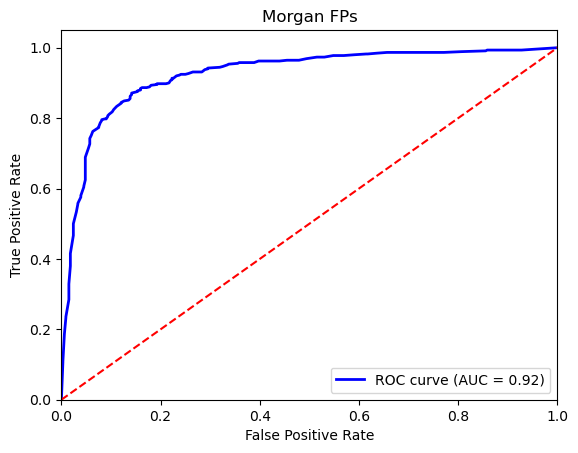

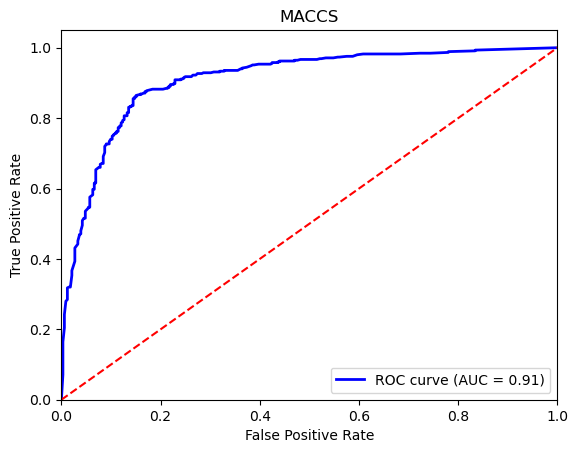

In [17]:
morgan_roc = random_forest(fps_morgan, morgan_y, "Morgan FPs", plot_roc=True)
maccs_roc = random_forest(fps_maccs, maccs_y, "MACCS", plot_roc=True)

### Task 5: Five-fold cross validation

In [18]:
def cross_validation(X, y):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    metrics_list = []
    X = np.array(X)
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        clf = RandomForestClassifier(n_estimators=100, random_state=0)
        clf.fit(X_train, y_train)
        
        y_pred = clf.predict(X_test)
        y_prob = clf.predict_proba(X_test)[:, 1]
        
        Accuracy, AUC, Sensitivity, Specificity = evaluate_metrics(y_test, y_pred, y_prob)
        
        metrics_list.append({
            "Accuracy": Accuracy,
            "AUC": AUC,
            "Sensitivity": Sensitivity,
            "Specificity": Specificity,
        })
    
    mean_metrics = {metric: np.mean([m[metric] for m in metrics_list]) for metric in metrics_list[0]}
    std_metrics = {metric: np.std([m[metric] for m in metrics_list]) for metric in metrics_list[0]}
    
    return {
        "Mean": mean_metrics,
        "Std": std_metrics
    }

morgan_cv = cross_validation(fps_morgan, morgan_y)
maccs_cv = cross_validation(fps_maccs, maccs_y)


In [19]:
mean = pd.DataFrame(index=['Accuracy', 'AUC', 'Sensitivity', 'Specificity'], columns=['Morgan FPs', 'MACCs'])
std = pd.DataFrame(index=['Accuracy', 'AUC', 'Sensitivity', 'Specificity'], columns=['Morgan FPs', 'MACCs'])

mean['Morgan FPs'] = [morgan_cv["Mean"][metric] for metric in mean.index]
mean['MACCs'] = [maccs_cv["Mean"][metric] for metric in mean.index]

std['Morgan FPs'] = [morgan_cv["Std"][metric] for metric in std.index]
std['MACCs'] = [maccs_cv["Std"][metric] for metric in std.index]

In [20]:
mean.apply(lambda x: round(x, 3))

,Morgan FPs,MACCs
Accuracy,0.859,0.831
AUC,0.920,0.896
Sensitivity,0.888,0.869
Specificity,0.822,0.781


In [21]:
std.apply(lambda x: round(x, 3))

,Morgan FPs,MACCs
Accuracy,0.014,0.014
AUC,0.012,0.013
Sensitivity,0.015,0.010
Specificity,0.028,0.027


### Task 6: Apply the chosen model on test compounds

#### The model chosen or screening task is obtained from Morgan fingerprints

In [23]:
forest = random_forest(fps_morgan, morgan_y, return_forest=True)
test_compounds = pd.read_csv("../data/test_compounds_EGFR.csv")
active_compounds = 0
inactive_compounds = 0
egfr_compounds = []
for _, row in test_compounds.iterrows():
    molecule = Chem.MolFromSmiles(row["canonical_smiles"])
    compounds_fp = AllChem.GetMorganFingerprintAsBitVect(molecule, radius=2, nBits=1024)
    compounds_fp = np.reshape(compounds_fp, (1, -1))
    y_pred = forest.predict(compounds_fp)
    y_prob = forest.predict_proba(compounds_fp)
    if y_pred == 1:
        active_compounds += 1
    elif y_pred == 0:
        inactive_compounds += 1
    egfr_compounds.append({"ChEMBL ID": row["chembl_id"], "Canonical Smiles": row["canonical_smiles"], "Prediction": y_pred[0], "Probability": y_prob[0][1]})
    
egfr_compounds_pred = pd.DataFrame(egfr_compounds)

#### Print number of active and inactive compounds

In [24]:
print(f"Active compounds: {active_compounds} \t Inactive compounds: {inactive_compounds}")
egfr_compounds_pred.head()

Active compounds: 653 	 Inactive compounds: 398


,ChEMBL ID,Canonical Smiles,Prediction,Probability
0,CHEMBL101253,Clc1ccc(Nc2nnc(Cc3ccncc3)c4ccccc24)cc1,0.0,0.42
1,CHEMBL107472,CNc1ncc2C=C(C(=O)N(C)c2n1)c3c(Cl)cccc3Cl,0.0,0.25
2,CHEMBL1077068,CC1=C(C(NC(=N1)Nc2ccc(cc2)S(=O)(=O)Nc3ncccn3)c...,0.0,0.22
3,CHEMBL1088240,COc1cc(Nc2c(cnc3cc(\C=C\CCN4CCN(C)CC4)c(OC)cc2...,1.0,0.62
4,CHEMBL1092382,CCC(=O)Nc1ccc2nccc(Nc3cccc(Br)c3)c2c1,1.0,0.65


### Task 7: Filter down to 20 compounds

#### Step 1: Select only active compounds

In [25]:
active_compounds_df = egfr_compounds_pred[egfr_compounds_pred["Prediction"] == 1]
active_compounds_df.head()

,ChEMBL ID,Canonical Smiles,Prediction,Probability
3,CHEMBL1088240,COc1cc(Nc2c(cnc3cc(\C=C\CCN4CCN(C)CC4)c(OC)cc2...,1.0,0.62
4,CHEMBL1092382,CCC(=O)Nc1ccc2nccc(Nc3cccc(Br)c3)c2c1,1.0,0.65
12,CHEMBL1097368,C(Cc1cc2c(Nc3ccc4[nH]ccc4c3)ncnc2[nH]1)c5ccccc5,1.0,0.63
14,CHEMBL113023,COc1ccc(Nc2ncc3C=C(C(=O)N(C)c3n2)c4c(Cl)cccc4C...,1.0,0.76
15,CHEMBL113070,CN1C(=O)C(=Cc2cnc(Nc3ccc(CCCC(=O)O)cc3)nc12)c4...,1.0,0.81


#### Step 2: Calculate molecular descriptors and test its violation

In [26]:
def lipinski_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    descriptors = {
        "Mol Weight": Descriptors.MolWt(mol),
        "HB acceptors": Descriptors.NumHAcceptors(mol),
        "HB donors": Descriptors.NumHDonors(mol),
        "LogP": Descriptors.MolLogP(mol)
    }

    if descriptors["Mol Weight"] <= 500 and descriptors["LogP"] <= 5 and \
            descriptors["HB donors"] <= 5 and descriptors["HB acceptors"] <= 10:
        descriptors["Lipinski Ro5"] = True  # Passes Lipinski's Rule of Five
    else:
        descriptors["Lipinski Ro5"] = False  # Violates Lipinski's Rule of Five
    return descriptors

active_compounds_df["LipinskiDescriptors"] = active_compounds_df["Canonical Smiles"].apply(lipinski_descriptors)
active_compounds_df = pd.concat([active_compounds_df.drop(['LipinskiDescriptors'], axis=1),
                                 active_compounds_df['LipinskiDescriptors'].apply(pd.Series)], axis=1)

C:\Users\Heshine G\AppData\Local\Temp\ipykernel_22704\4197808160.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  active_compounds_df["LipinskiDescriptors"] = active_compounds_df["Canonical Smiles"].apply(lipinski_descriptors)


In [27]:
active_compounds_df

,ChEMBL ID,Canonical Smiles,Prediction,Probability,Mol Weight,HB acceptors,HB donors,LogP,Lipinski Ro5
3,CHEMBL1088240,COc1cc(Nc2c(cnc3cc(\C=C\CCN4CCN(C)CC4)c(OC)cc2...,1.0,0.62,526.468,7,1,5.82478,False
4,CHEMBL1092382,CCC(=O)Nc1ccc2nccc(Nc3cccc(Br)c3)c2c1,1.0,0.65,370.250,3,2,5.08940,False
12,CHEMBL1097368,C(Cc1cc2c(Nc3ccc4[nH]ccc4c3)ncnc2[nH]1)c5ccccc5,1.0,0.63,353.429,3,3,4.96800,True
14,CHEMBL113023,COc1ccc(Nc2ncc3C=C(C(=O)N(C)c3n2)c4c(Cl)cccc4C...,1.0,0.76,441.318,6,1,5.36292,False
15,CHEMBL113070,CN1C(=O)C(=Cc2cnc(Nc3ccc(CCCC(=O)O)cc3)nc12)c4...,1.0,0.81,483.355,6,2,5.45320,False
...,...,...,...,...,...,...,...,...,...
1043,CHEMBL93464,C\C=C\C(=O)Nc1ccc2ncnc(Nc3cccc(Br)c3)c2c1,1.0,0.94,383.249,4,2,4.65050,True
1044,CHEMBL93754,Brc1cccc(Nc2ncnc3ccc(NC(=O)\C=C\Cn4cccn4)cc23)c1,1.0,0.98,449.312,6,2,4.52730,True
1045,CHEMBL94019,COc1cc2ncnc(NC3CCc4ccccc34)c2cc1OC,1.0,0.78,321.380,5,1,3.74640,True
1046,CHEMBL94061,CN(C)C\C=C\C(=O)Nc1ccc2ncnc(Nc3cccc(Br)c3)c2c1,1.0,0.99,426.318,5,2,4.19220,True


#### Step 3: Select compounds that satisfies lipinski rule of five

In [28]:
active_compounds_df = active_compounds_df[active_compounds_df["Lipinski Ro5"]]

In [29]:
active_compounds_df

,ChEMBL ID,Canonical Smiles,Prediction,Probability,Mol Weight,HB acceptors,HB donors,LogP,Lipinski Ro5
12,CHEMBL1097368,C(Cc1cc2c(Nc3ccc4[nH]ccc4c3)ncnc2[nH]1)c5ccccc5,1.0,0.63,353.429,3,3,4.96800,True
22,CHEMBL116919,COc1ccc(CNc2ncnc3ccccc23)cc1,1.0,0.60,265.316,4,1,3.25050,True
44,CHEMBL118130,Oc1ccc(cc1)c2[nH]nc3ncnc(Nc4cccc(Cl)c4)c23,1.0,0.89,337.770,5,3,4.12250,True
46,CHEMBL120069,Cc1cccc(Nc2[nH]cnc3nnc(Nc4cccc(Cl)c4)c23)c1,1.0,0.75,350.813,5,3,4.75352,True
49,CHEMBL1204168,Cl.COc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OC,1.0,0.97,396.672,5,1,4.57490,True
...,...,...,...,...,...,...,...,...,...
1043,CHEMBL93464,C\C=C\C(=O)Nc1ccc2ncnc(Nc3cccc(Br)c3)c2c1,1.0,0.94,383.249,4,2,4.65050,True
1044,CHEMBL93754,Brc1cccc(Nc2ncnc3ccc(NC(=O)\C=C\Cn4cccn4)cc23)c1,1.0,0.98,449.312,6,2,4.52730,True
1045,CHEMBL94019,COc1cc2ncnc(NC3CCc4ccccc34)c2cc1OC,1.0,0.78,321.380,5,1,3.74640,True
1046,CHEMBL94061,CN(C)C\C=C\C(=O)Nc1ccc2ncnc(Nc3cccc(Br)c3)c2c1,1.0,0.99,426.318,5,2,4.19220,True


#### Step 4: Filter compounds that have higher active probability of >=0.65

In [30]:
active_compounds_df = active_compounds_df[active_compounds_df["Probability"] >= 0.65]

In [31]:
active_compounds_df

,ChEMBL ID,Canonical Smiles,Prediction,Probability,Mol Weight,HB acceptors,HB donors,LogP,Lipinski Ro5
44,CHEMBL118130,Oc1ccc(cc1)c2[nH]nc3ncnc(Nc4cccc(Cl)c4)c23,1.0,0.89,337.770,5,3,4.12250,True
46,CHEMBL120069,Cc1cccc(Nc2[nH]cnc3nnc(Nc4cccc(Cl)c4)c23)c1,1.0,0.75,350.813,5,3,4.75352,True
49,CHEMBL1204168,Cl.COc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OC,1.0,0.97,396.672,5,1,4.57490,True
50,CHEMBL120667,Cc1c(C)n(C)c2ncnc(Nc3cccc(Cl)c3)c12,1.0,0.76,286.766,4,1,3.98214,True
51,CHEMBL121190,Nc1[nH]cnc2nnc(Nc3cccc(Cl)c3)c12,1.0,0.70,260.688,5,3,2.28370,True
...,...,...,...,...,...,...,...,...,...
1043,CHEMBL93464,C\C=C\C(=O)Nc1ccc2ncnc(Nc3cccc(Br)c3)c2c1,1.0,0.94,383.249,4,2,4.65050,True
1044,CHEMBL93754,Brc1cccc(Nc2ncnc3ccc(NC(=O)\C=C\Cn4cccn4)cc23)c1,1.0,0.98,449.312,6,2,4.52730,True
1045,CHEMBL94019,COc1cc2ncnc(NC3CCc4ccccc34)c2cc1OC,1.0,0.78,321.380,5,1,3.74640,True
1046,CHEMBL94061,CN(C)C\C=C\C(=O)Nc1ccc2ncnc(Nc3cccc(Br)c3)c2c1,1.0,0.99,426.318,5,2,4.19220,True


#### Step 5: Compare the substructure of known EGFR compounds to the test compounds and select only that contains substructure

In [32]:
active_molecules = [Chem.MolFromSmiles(s) for s in active_compounds_df["Canonical Smiles"]]
known_egfr_compounds = pd.read_csv("../data/Compound_information.csv")
molecules = [Chem.MolFromSmiles(s) for s in known_egfr_compounds["SMILES"]]
substructure=rdFMCS.FindMCS(molecules)
substructure_pattern = Chem.MolFromSmarts(substructure.smartsString)
contains_substructure = []
for test_mol in active_molecules:
    if test_mol.HasSubstructMatch(substructure_pattern):
        contains_substructure.append(True)
    else:
        contains_substructure.append(False)
        
active_compounds_df["Substructure"] = contains_substructure

C:\Users\Heshine G\AppData\Local\Temp\ipykernel_22704\3872735810.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  active_compounds_df["Substructure"] = contains_substructure


In [33]:
active_compounds_df

,ChEMBL ID,Canonical Smiles,Prediction,Probability,Mol Weight,HB acceptors,HB donors,LogP,Lipinski Ro5,Substructure
44,CHEMBL118130,Oc1ccc(cc1)c2[nH]nc3ncnc(Nc4cccc(Cl)c4)c23,1.0,0.89,337.770,5,3,4.12250,True,False
46,CHEMBL120069,Cc1cccc(Nc2[nH]cnc3nnc(Nc4cccc(Cl)c4)c23)c1,1.0,0.75,350.813,5,3,4.75352,True,False
49,CHEMBL1204168,Cl.COc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OC,1.0,0.97,396.672,5,1,4.57490,True,True
50,CHEMBL120667,Cc1c(C)n(C)c2ncnc(Nc3cccc(Cl)c3)c12,1.0,0.76,286.766,4,1,3.98214,True,False
51,CHEMBL121190,Nc1[nH]cnc2nnc(Nc3cccc(Cl)c3)c12,1.0,0.70,260.688,5,3,2.28370,True,False
...,...,...,...,...,...,...,...,...,...,...
1043,CHEMBL93464,C\C=C\C(=O)Nc1ccc2ncnc(Nc3cccc(Br)c3)c2c1,1.0,0.94,383.249,4,2,4.65050,True,True
1044,CHEMBL93754,Brc1cccc(Nc2ncnc3ccc(NC(=O)\C=C\Cn4cccn4)cc23)c1,1.0,0.98,449.312,6,2,4.52730,True,True
1045,CHEMBL94019,COc1cc2ncnc(NC3CCc4ccccc34)c2cc1OC,1.0,0.78,321.380,5,1,3.74640,True,False
1046,CHEMBL94061,CN(C)C\C=C\C(=O)Nc1ccc2ncnc(Nc3cccc(Br)c3)c2c1,1.0,0.99,426.318,5,2,4.19220,True,True


In [34]:
active_compounds_df = active_compounds_df[active_compounds_df['Substructure']]

#### Step 6: Prioritize the compounds with higher active probability and select top 20

In [35]:
filtered_compounds = active_compounds_df.sort_values(by="Probability", ascending=False)

In [36]:
selected_candidates = filtered_compounds.head(20)

In [37]:
selected_candidates

,ChEMBL ID,Canonical Smiles,Prediction,Probability,Mol Weight,HB acceptors,HB donors,LogP,Lipinski Ro5,Substructure
381,CHEMBL272895,Brc1cccc(Nc2ncnc3ccncc23)c1NCCCCN4CCOCC4,1.0,1.0,457.376,7,2,4.0552,True,True
437,CHEMBL3114688,O=C(\C=C\CN1CCCCC1)N2CCOc3cc4ncnc(Nc5cccc(c5)C...,1.0,1.0,453.546,6,1,4.1222,True,True
310,CHEMBL2334001,COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OCCO,1.0,1.0,363.776,6,2,3.5456,True,True
539,CHEMBL3360607,COc1cc2c(Nc3cccc(c3)C#C)ncnc2cc1OCCCn4ccnc4[N+...,1.0,1.0,444.451,9,1,3.9371,True,True
540,CHEMBL3360609,COc1cc2c(Nc3cccc(c3)C#C)ncnc2cc1OCCCCCn4ccnc4[...,1.0,1.0,472.505,9,1,4.7173,True,True
549,CHEMBL340484,CN1CCN(CCCNc2cc3ncnc(Nc4cccc(Br)c4)c3cn2)CC1,1.0,1.0,456.392,7,2,3.5803,True,True
554,CHEMBL341319,CN(CCO)c1cc2ncnc(Nc3cccc(Br)c3)c2cn1,1.0,1.0,374.242,6,2,2.9594,True,True
85,CHEMBL126623,Brc1cccc(Nc2ncnc3cc(NCCCN4CCOCC4)ncc23)c1,1.0,1.0,443.349,7,2,3.6651,True,True
260,CHEMBL204085,Fc1ccc(Nc2ncnc3ccc(NC(=O)C#CCCN4CCOCC4)cc23)cc1Cl,1.0,1.0,453.905,6,2,3.8301,True,True
583,CHEMBL3622617,COCCOc1cc2ncnc(Nc3cccc(c3)C#C)c2cc1NC(=O)C=C,1.0,1.0,388.427,6,2,3.5044,True,True


### Task 8: Draw the grid images of selected compounds and label it

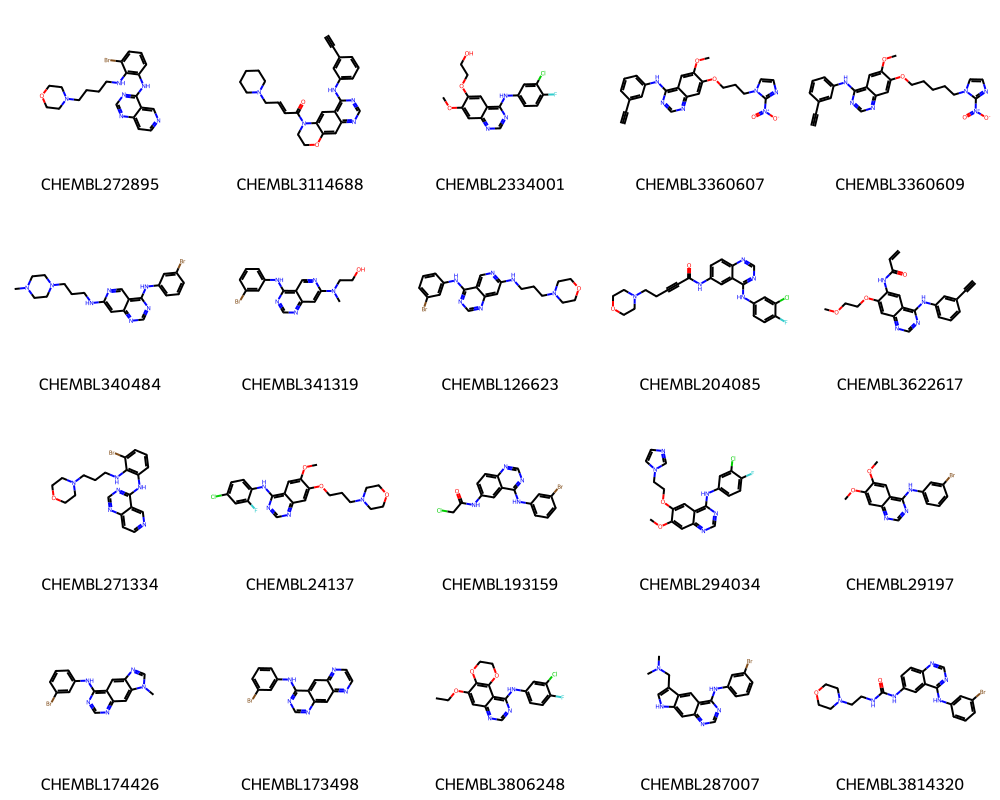

In [38]:
selected_molecules = [Chem.MolFromSmiles(s) for s in selected_candidates["Canonical Smiles"]]
names = selected_candidates["ChEMBL ID"].tolist()
Draw.MolsToGridImage(selected_molecules, legends=names, molsPerRow=5)